In [ ]:
from google.colab import files
from IPython.display import clear_output
files.upload()
clear_output()

In [ ]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [ ]:
%load_ext pycodestyle_magic

In [ ]:
import re
import time
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from string import ascii_lowercase
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
clear_output()

# Задание 1
## Препроцессинг данных

In [ ]:
russian = 'абвгдеёжзийклмнопрстуфхцчшщьыъэюя'
CHAR_TO_INDEX = {w: i for i, w in enumerate(russian, 1)}
CHAR_TO_INDEX[' '] = 34

In [ ]:
def caesar_encode(text, k):
    cipher = ''
    for char in text:
        if char.lower() in russian:
            id = (CHAR_TO_INDEX[char.lower()] + k) % 33
            if char.isupper():
                cipher += russian[id].upper()
            else:
                cipher += russian[id]
        else:
            cipher += char
    return cipher

In [ ]:
regex = r'(\[\d+\] \(#litres_trial_promo\)|\[.*\]|\t+)'

# обнаружилась странная ошибка – первое "Не" в тексте оказалось записано латиницей
with open('onegin.txt') as f:
    sents = [re.sub(regex, '', sent).replace('\xa0', ' ').replace('He', 'Не')
             for sent in f.read().splitlines()
             if sent.startswith('\t\t') and not sent.endswith('………')]

In [ ]:
len(sents)

1453

In [ ]:
sents[:10]

['Не мысля гордый свет забавить,',
 'Вниманье дружбы возлюбя,',
 'Хотел бы я тебе представить',
 'Залог достойнее тебя,',
 'Достойнее души прекрасной,',
 'Святой исполненной мечты,',
 'Поэзии живой и ясной,',
 'Высоких дум и простоты;',
 'Но так и быть – рукой пристрастной',
 'Прими собранье пёстрых глав,']

In [ ]:
sents_ciphered = [caesar_encode(sent, 3) for sent in sents]

In [ ]:
sents_ciphered[:10]

['Си ряхпг жтфзян хёиц лдедёмцю,',
 'Ёсмрдсюи зфчкея ётлпвег,',
 'Щтцип ея г циеи уфизхцдёмцю',
 'Лдптж зтхцтнсии циег,',
 'Зтхцтнсии зчъм уфиофдхстн,',
 'Хёгцтн мхутпсисстн риыця,',
 'Утблмм кмётн м гхстн,',
 'Ёяхтомщ зчр м уфтхцтця;',
 'Ст цдо м еяцю – фчотн уфмхцфдхцстн',
 'Уфмрм хтефдсюи уйхцфящ жпдё,']

Посчитаем среднюю длину строки в стихотворении, чтобы выяснить, до какой длины делать padding.

In [ ]:
np.mean([len(sent) for sent in sents])

25.044046799724708

In [ ]:
MAX_LEN = 25

X = torch.zeros((len(sents), MAX_LEN), dtype=int)
for i in range(len(sents)):
    for j, w in enumerate(sents[i]):
        if j >= MAX_LEN:
            break
        if w.lower() in CHAR_TO_INDEX:
            X[i][j] = CHAR_TO_INDEX[w.lower()]

In [ ]:
X[:10]

tensor([[15,  6, 34, 14, 29, 19, 13, 33, 34,  4, 16, 18,  5, 29, 11, 34, 19,  3,
          6, 20, 34,  9,  1,  2,  1],
        [ 3, 15, 10, 14,  1, 15, 28,  6, 34,  5, 18, 21,  8,  2, 29, 34,  3, 16,
          9, 13, 32,  2, 33,  0,  0],
        [23, 16, 20,  6, 13, 34,  2, 29, 34, 33, 34, 20,  6,  2,  6, 34, 17, 18,
          6,  5, 19, 20,  1,  3, 10],
        [ 9,  1, 13, 16,  4, 34,  5, 16, 19, 20, 16, 11, 15,  6,  6, 34, 20,  6,
          2, 33,  0,  0,  0,  0,  0],
        [ 5, 16, 19, 20, 16, 11, 15,  6,  6, 34,  5, 21, 26, 10, 34, 17, 18,  6,
         12, 18,  1, 19, 15, 16, 11],
        [19,  3, 33, 20, 16, 11, 34, 10, 19, 17, 16, 13, 15,  6, 15, 15, 16, 11,
         34, 14,  6, 25, 20, 29,  0],
        [17, 16, 31,  9, 10, 10, 34,  8, 10,  3, 16, 11, 34, 10, 34, 33, 19, 15,
         16, 11,  0,  0,  0,  0,  0],
        [ 3, 29, 19, 16, 12, 10, 23, 34,  5, 21, 14, 34, 10, 34, 17, 18, 16, 19,
         20, 16, 20, 29,  0,  0,  0],
        [15, 16, 34, 20,  1, 12, 34, 10, 34,  2,

In [ ]:
MAX_LEN = 25

y = torch.zeros((len(sents_ciphered), MAX_LEN), dtype=int)
for i in range(len(sents_ciphered)):
    for j, w in enumerate(sents_ciphered[i]):
        if j >= MAX_LEN:
            break
        if w.lower() in CHAR_TO_INDEX:
            y[i][j] = CHAR_TO_INDEX[w.lower()]

In [ ]:
y[:10]

tensor([[19, 10, 34, 18, 33, 23, 17,  4, 34,  8, 20, 22,  9, 33, 15, 34, 23,  7,
         10, 24, 34, 13,  5,  6,  5],
        [ 7, 19, 14, 18,  5, 19, 32, 10, 34,  9, 22, 25, 12,  6, 33, 34,  7, 20,
         13, 17,  3,  6,  4,  0,  0],
        [27, 20, 24, 10, 17, 34,  6, 33, 34,  4, 34, 24, 10,  6, 10, 34, 21, 22,
         10,  9, 23, 24,  5,  7, 14],
        [13,  5, 17, 20,  8, 34,  9, 20, 23, 24, 20, 15, 19, 10, 10, 34, 24, 10,
          6,  4,  0,  0,  0,  0,  0],
        [ 9, 20, 23, 24, 20, 15, 19, 10, 10, 34,  9, 25, 30, 14, 34, 21, 22, 10,
         16, 22,  5, 23, 19, 20, 15],
        [23,  7,  4, 24, 20, 15, 34, 14, 23, 21, 20, 17, 19, 10, 19, 19, 20, 15,
         34, 18, 10, 29, 24, 33,  0],
        [21, 20,  2, 13, 14, 14, 34, 12, 14,  7, 20, 15, 34, 14, 34,  4, 23, 19,
         20, 15,  0,  0,  0,  0,  0],
        [ 7, 33, 23, 20, 16, 14, 27, 34,  9, 25, 18, 34, 14, 34, 21, 22, 20, 23,
         24, 20, 24, 33,  0,  0,  0],
        [19, 20, 34, 24,  5, 16, 34, 14, 34,  6,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Архитектура RNN

In [ ]:
class CaesarNetwork(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(CaesarNetwork, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dense = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, train=True, state=None):
        with torch.set_grad_enabled(train):
            out = self.embedding(x)
            out, state = self.rnn(out, state)
            out = self.dense(out)
            out = out.squeeze(0)
        return out, state

## Обучение

In [ ]:
vocab_size = 35
embedding_dim = 35
hidden_dim = 128

In [ ]:
model = CaesarNetwork(vocab_size, embedding_dim, hidden_dim)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
batch_size = 64
n_epochs = 100

In [ ]:
train_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    start = time.time()
    train_loss = 0.0
    n_batches = int(np.ceil(len(X_train) / batch_size))
    for i in range(n_batches):
        X_batch = X_train[batch_size * i: batch_size * (i + 1)]
        y_batch = y_train[batch_size * i: batch_size * (i + 1)].flatten()
        optimizer.zero_grad()
        y_pred, _ = model.forward(X_batch)
        loss = criterion(y_pred.view(-1, 35), y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= n_batches
    train_losses.append(train_loss)
    sec = time.time() - start
    print(f'Epoch: {epoch}, time: {sec:.1f}s, train loss: {train_loss:.3f}')

Epoch: 1, time: 0.6s, train loss: 3.098
Epoch: 2, time: 0.3s, train loss: 2.177
Epoch: 3, time: 0.3s, train loss: 1.585
Epoch: 4, time: 0.3s, train loss: 1.209
Epoch: 5, time: 0.3s, train loss: 0.954
Epoch: 6, time: 0.3s, train loss: 0.773
Epoch: 7, time: 0.3s, train loss: 0.639
Epoch: 8, time: 0.3s, train loss: 0.538
Epoch: 9, time: 0.3s, train loss: 0.459
Epoch: 10, time: 0.3s, train loss: 0.397
Epoch: 11, time: 0.3s, train loss: 0.348
Epoch: 12, time: 0.3s, train loss: 0.308
Epoch: 13, time: 0.3s, train loss: 0.275
Epoch: 14, time: 0.3s, train loss: 0.248
Epoch: 15, time: 0.3s, train loss: 0.226
Epoch: 16, time: 0.3s, train loss: 0.207
Epoch: 17, time: 0.3s, train loss: 0.190
Epoch: 18, time: 0.3s, train loss: 0.176
Epoch: 19, time: 0.3s, train loss: 0.163
Epoch: 20, time: 0.3s, train loss: 0.152
Epoch: 21, time: 0.3s, train loss: 0.142
Epoch: 22, time: 0.3s, train loss: 0.134
Epoch: 23, time: 0.3s, train loss: 0.126
Epoch: 24, time: 0.3s, train loss: 0.119
Epoch: 25, time: 0.3s, tr

# Оценка качества
Построим график лоссов на обучающей выборке и оценим качество на тестовой.

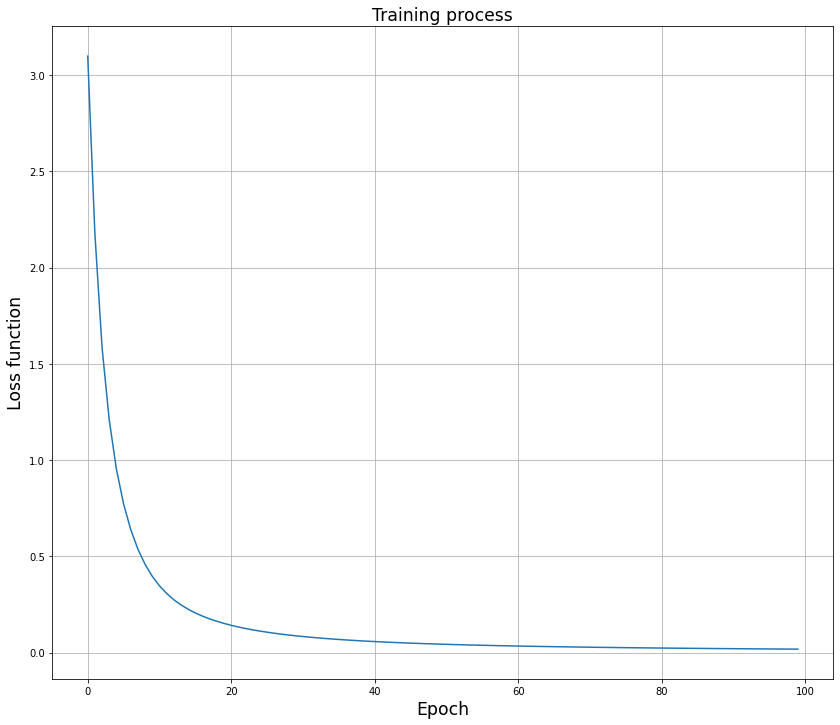

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(train_losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

In [ ]:
y_pred, _ = model.forward(X_test, train=False)
loss = criterion(y_pred.view(-1, 35), y_test.flatten())

In [ ]:
print(f'Лосс на тестовой выборке: {loss.item():.3f}')

Лосс на тестовой выборке: 0.022


Очень неплохо!

# Задание 2
## Препроцессинг данных

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

,Unnamed: 0,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,0,10368,35,29,"Lisa Simpson: Maggie, look. What's that?",235000,True,9,5.0,Lisa Simpson,Simpson Home,"Maggie, look. What's that?",maggie look whats that,4.0
1,1,10369,35,30,Lisa Simpson: Lee-mur. Lee-mur.,237000,True,9,5.0,Lisa Simpson,Simpson Home,Lee-mur. Lee-mur.,lee-mur lee-mur,2.0
2,2,10370,35,31,Lisa Simpson: Zee-boo. Zee-boo.,239000,True,9,5.0,Lisa Simpson,Simpson Home,Zee-boo. Zee-boo.,zee-boo zee-boo,2.0
3,3,10372,35,33,Lisa Simpson: I'm trying to teach Maggie that ...,245000,True,9,5.0,Lisa Simpson,Simpson Home,I'm trying to teach Maggie that nature doesn't...,im trying to teach maggie that nature doesnt e...,24.0
4,4,10374,35,35,"Lisa Simpson: It's like an ox, only it has a h...",254000,True,9,5.0,Lisa Simpson,Simpson Home,"It's like an ox, only it has a hump and a dewl...",its like an ox only it has a hump and a dewlap...,18.0


In [ ]:
sents = df['normalized_text'].tolist()

In [ ]:
len(sents)

11639

In [ ]:
sents[:10]

['maggie look whats that',
 'lee-mur lee-mur',
 'zee-boo zee-boo',
 'im trying to teach maggie that nature doesnt end with the barnyard i want her to have all the advantages that i didnt have',
 'its like an ox only it has a hump and a dewlap hump and dew-lap hump and dew-lap',
 'you know his blood type how romantic',
 'oh yeah whats my shoe size',
 'ring',
 'yes dad',
 'ooh look maggie what is that do-dec-ah-edron dodecahedron']

In [ ]:
text = [[char for char in sent] for sent in sents if isinstance(sent, str)]

In [ ]:
text[0]

['m',
 'a',
 'g',
 'g',
 'i',
 'e',
 ' ',
 'l',
 'o',
 'o',
 'k',
 ' ',
 'w',
 'h',
 'a',
 't',
 's',
 ' ',
 't',
 'h',
 'a',
 't']

In [ ]:
CHAR_TO_INDEX = {w: i for i, w in enumerate(ascii_lowercase, 1)}
CHAR_TO_INDEX[' '] = 27

Посчитаем среднюю длину реплики, чтобы выяснить, до какой длины делать padding.

In [ ]:
np.mean([len(sent) for sent in text])

46.36635754292535

Да, действительно, лучше до 50.

In [ ]:
MAX_LEN = 50

X = torch.zeros((len(text), MAX_LEN), dtype=int)
for i in range(len(text)):
    for j, w in enumerate(text[i]):
        if j >= MAX_LEN:
            break
        if w.lower() in CHAR_TO_INDEX:
            X[i][j] = CHAR_TO_INDEX[w.lower()]

In [ ]:
X[:10]

tensor([[13,  1,  7,  7,  9,  5, 27, 12, 15, 15, 11, 27, 23,  8,  1, 20, 19, 27,
         20,  8,  1, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [12,  5,  5,  0, 13, 21, 18, 27, 12,  5,  5,  0, 13, 21, 18,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [26,  5,  5,  0,  2, 15, 15, 27, 26,  5,  5,  0,  2, 15, 15,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 9, 13, 27, 20, 18, 25,  9, 14,  7, 27, 20, 15, 27, 20,  5,  1,  3,  8,
         27, 13,  1,  7,  7,  9,  5, 27, 20,  8,  1, 20, 27, 14,  1, 20, 21, 18,
          5, 27,  4, 15,  5, 19, 14, 20, 27,  5, 14,  4, 27, 23],
        [ 9, 20, 19, 27, 12,  9, 11,  5, 27,  1, 14, 27, 15, 24, 27, 15, 14, 12,
       

## Архитектура RNN

In [ ]:
class TextGenerationNetwork(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(TextGenerationNetwork, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dense = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, train=True, state=None):
        with torch.set_grad_enabled(train):
            out = self.embedding(x)
            out, state = self.rnn(out)
            out = self.dense(out)
            out = out.squeeze(0)
        return out, state

In [ ]:
# я решила добавить ограничение на длину сгенерированного предложения

def generate_sentence(model):
    sent = 'hello'
    id = -1
    while id != 0 and len(sent) < MAX_LEN:
        sent_as_tensor = [torch.as_tensor(
            np.array([[CHAR_TO_INDEX[char]]]),
            dtype=torch.long) for char in sent]
        state = None
        for char in sent_as_tensor:
            out, state = model.forward(char, train=False, state=state)
        id = np.argmax(out.numpy().flatten())
        if id == 27:
            sent += ' '
        else:
            sent += ascii_lowercase[id - 1]
    return sent

## Обучение и генерация предложений на каждой эпохе

In [ ]:
vocab_size = 28
embedding_dim = 28
hidden_dim = 128

In [ ]:
model = TextGenerationNetwork(vocab_size, embedding_dim, hidden_dim)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
batch_size = 100
n_epochs = 100

In [ ]:
train_losses = []

for epoch in tqdm(range(1, n_epochs + 1)):
    start = time.time()
    train_loss = 0.0
    n_batches = int(np.ceil(len(X_train) / batch_size))
    for i in range(n_batches):
        batch = X[i * batch_size: (i + 1) * batch_size]
        X_batch = batch[:, :-1]
        y_batch = batch[:, 1:].flatten()
        optimizer.zero_grad()
        y_pred, _ = model.forward(X_batch)
        loss = criterion(y_pred.view(-1, 28), y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= n_batches
    train_losses.append(train_loss)
    sec = time.time() - start
    print(f'Epoch: {epoch}, time: {sec:.1f}s, train loss: {train_loss:.3f}')
    print(generate_sentence(model) + '\n')

Epoch: 1, time: 0.5s, train loss: 2.581
helloz

Epoch: 2, time: 0.5s, train loss: 2.190
helloz

Epoch: 3, time: 0.5s, train loss: 2.122
helloz

Epoch: 4, time: 0.5s, train loss: 2.064
helloz

Epoch: 5, time: 0.5s, train loss: 2.006
helloz

Epoch: 6, time: 0.5s, train loss: 1.956
helloz

Epoch: 7, time: 0.5s, train loss: 1.920
helloooooooooooooooooooooooooooooooooooooooooooooo

Epoch: 8, time: 0.5s, train loss: 1.894
hellou t t t t t t t t t t t t t t t t t t t t t t

Epoch: 9, time: 0.5s, train loss: 1.874
hellou t t t t t t t t t t t t t t t t t t t t t t

Epoch: 10, time: 0.5s, train loss: 1.858
hellou t t t t t t t t t t t t t t t t t t t t t t

Epoch: 11, time: 0.5s, train loss: 1.845
hellou t t t t t t t t t t t t t t t t t t t t t t

Epoch: 12, time: 0.5s, train loss: 1.833
hellou t t t t t t t t t t t t t t t t t t t t t t

Epoch: 13, time: 0.5s, train loss: 1.822
hellou t t t t t t t t t t t t t t t t t t t t t t

Epoch: 14, time: 0.5s, train loss: 1.811
hellou t t t t t t t t 

Фигню какую-то генерирует. Что-то я делаю не так. Или он и должен генерировать фигню?<br>
Построим график лоссов.

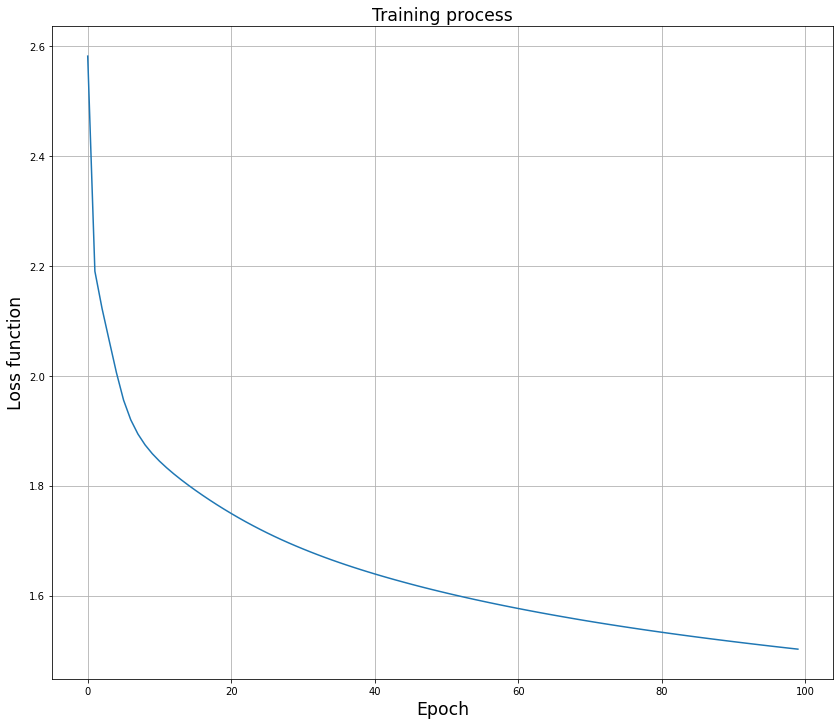

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(train_losses)
plt.grid()
plt.title('Training process', fontsize='xx-large')
plt.xlabel('Epoch', fontsize='xx-large')
plt.ylabel('Loss function', fontsize='xx-large')
plt.show()

Ну хотя бы лосс нормальный!